由于已经完成了框架的外部组件，我们只需要设计输入如何处理原始信息的模块，这里我们设计一个最普通的Transformer 的多层Encoder

In [52]:
import os
os.chdir('d:/future/index_future_prediction/Index_Future_Prediction')

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [53]:
from utils.random_split import RandomSplit
from utils.back_test import BackTest
from utils.hybrid_loss import HybridLoss
from utils.hybrid_decoder import HybridDecoder
from utils.prediction_recorder import PredictionRecorder
from utils.train_animator import TrainAnimator
from utils.model_train import ModelTrain

In [54]:
data = pd.read_csv('data/feature.csv', index_col='Unnamed: 0')
data

,trade_date,near_month_discount_rate,far_month_discount_rate,open_change,close_change,high_change,low_change,5_day_relative_MA,10_day_relative_MA,20_day_relative_MA,60_day_relative_MA,MACD,RSI,ATR,VROC,WVAD,BOLL_UP,BOLL_DOWN
0,20170914,0.017573,0.011328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,-0.556669,NaN,NaN
1,20170915,0.033793,0.015250,-0.001191,-0.001669,0.001757,-0.004903,NaN,NaN,NaN,NaN,-0.631948,NaN,NaN,NaN,-0.071747,NaN,NaN
2,20170918,0.042724,0.021426,0.000683,0.002174,0.009625,0.000683,NaN,NaN,NaN,NaN,-0.152188,NaN,NaN,NaN,0.166723,NaN,NaN
3,20170919,0.019654,0.016886,0.002446,-0.001303,0.004864,-0.004699,NaN,NaN,NaN,NaN,-0.343472,NaN,NaN,NaN,-0.391977,NaN,NaN
4,20170920,0.039351,0.018870,-0.001292,-0.003020,0.001692,-0.003304,-0.002665,NaN,NaN,NaN,-1.577283,NaN,NaN,NaN,-0.345759,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859,20250911,0.074557,0.003580,-0.004740,0.014795,0.014834,-0.007410,0.012354,0.010018,0.022227,0.061283,-7.842738,-1.743744,0.031168,0.069159,0.878206,0.007448,-0.027285
1860,20250912,0.000725,0.001542,0.000986,-0.004875,0.005329,-0.006201,0.005621,0.004828,0.014826,0.054330,-7.190298,-1.482886,0.029694,0.016771,-0.508293,0.012887,-0.022497
1861,20250915,-0.004544,0.000628,0.002629,-0.001996,0.005496,-0.003646,0.002071,0.003293,0.010559,0.050468,-8.055094,-1.388847,0.027619,-0.124636,-0.505905,0.013802,-0.020367
1862,20250916,0.078527,0.003290,0.002234,-0.004993,0.004163,-0.006858,-0.004225,-0.000191,0.003648,0.043532,-11.016892,-1.181044,0.026605,-0.042803,-0.655748,0.014471,-0.014090


In [55]:
data['month'] = pd.to_datetime(data['trade_date'], format='%Y%m%d').dt.month
data['weekday'] = pd.to_datetime(data['trade_date'], format='%Y%m%d').dt.weekday
data['day'] = pd.to_datetime(data['trade_date'], format='%Y%m%d').dt.day

In [56]:
feature_columns = ['near_month_discount_rate', 'far_month_discount_rate', 'open_change',
       'close_change', 'high_change', 'low_change', '5_day_relative_MA',
       '10_day_relative_MA', '20_day_relative_MA', '60_day_relative_MA',
       'MACD', 'RSI', 'ATR', 'VROC', 'WVAD', 'BOLL_UP', 'BOLL_DOWN',
       'month', 'weekday', 'day',
       ]

data.dropna(inplace=True)
data = data.set_index('trade_date')

In [57]:
label = pd.read_csv('data/label.csv', index_col='Unnamed: 0')
label = label.set_index('trade_date')
data = pd.concat([data, label], axis = 1)

In [58]:
data

,near_month_discount_rate,far_month_discount_rate,open_change,close_change,high_change,low_change,5_day_relative_MA,10_day_relative_MA,20_day_relative_MA,60_day_relative_MA,...,BOLL_UP,BOLL_DOWN,month,weekday,day,ch_next_week,alter_std,down_probability,middle_probability,up_probability
trade_date,,,,,,,,,,,,,,,,,,,,,
20171215,0.013762,0.015700,-0.002086,-0.010484,-0.001238,-0.011483,-0.013407,-0.015795,-0.025578,0.007924,...,0.034561,-0.002465,12.0,4.0,15.0,60.6059,44.390405,0.008679,0.353905,0.637416
20171218,0.024692,0.020409,0.000444,0.003153,0.008030,-0.001541,-0.005422,-0.011577,-0.020649,0.010162,...,0.031895,-0.008469,12.0,0.0,18.0,65.2773,42.532369,0.004760,0.312010,0.683230
20171219,0.026301,0.018464,0.000173,0.015543,0.015745,-0.000573,0.008418,0.005101,-0.004253,0.024615,...,0.011302,-0.021452,12.0,1.0,19.0,-33.3956,44.393260,0.396892,0.564405,0.038703
20171220,0.013765,0.014791,0.000357,0.002302,0.004943,-0.004000,0.010263,0.007276,-0.000098,0.025720,...,0.009358,-0.023806,12.0,2.0,20.0,-20.5897,46.169833,0.298504,0.623782,0.077714
20171221,0.034639,0.021407,-0.002764,0.005460,0.009433,-0.006047,0.012559,0.011132,0.007408,0.029947,...,0.007046,-0.029065,12.0,3.0,21.0,-34.9296,48.519368,0.417789,0.532471,0.049740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20171208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-45.1741,44.397883,0.501564,0.477310,0.021125
20171211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-70.0451,43.824301,0.716166,0.279504,0.004331
20171212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,22.8333,40.359805,0.046409,0.662166,0.291425


In [59]:
data_set = RandomSplit(data, 'cuda:0')
data_set.set_output(feature_columns, dtype = torch.float32, unfold = True)
data_set.set_output(['ch_next_week', 'down_probability', 'middle_probability', 'up_probability'], dtype = torch.float32, unfold = False)
train_set, validation_set, test_set = data_set.get_split_data(700, 250, 250, 30)

In [60]:
loss_fn = HybridLoss(alpha = 1e-2, delta = 1)
recorder = PredictionRecorder(is_logits = True)
animator = TrainAnimator(figsize=(12,6))

Animator data has been reset.


In [61]:
from modules import embedding
class Embedding(nn.Module):
    def __init__(self, dim_temporal_embedding):
        super(Embedding, self).__init__()
        self.temporal_embed = embedding.TemporalEmbedding(embed_size = dim_temporal_embedding)
        self.calender_embed = embedding.CalendarEmbedding()

    def forward(self, market_feature):
        batch = market_feature.size()[0]
        length = market_feature.size()[1]
        relative_date = torch.arange(0,length).unsqueeze(0).broadcast_to((batch, length)).to('cuda:0')
        absolute_date = market_feature[:,:,-3:].int()

        return torch.cat((
            market_feature[:,:,:-3],
            self.temporal_embed(relative_date),
            self.calender_embed(absolute_date),
        ),
        dim = -1)

In [62]:
from modules import encoder
class Encoder_LSTM(nn.Module):
    def __init__(self, hidden_size, num_layers, dropout, **kwargs):
        super(Encoder_LSTM, self).__init__(**kwargs)
        self.device = 'cuda:0'
        self.embed = Embedding(7)
        self.encoder = encoder.MultiLayerEncoder(
            batch_size = 100,
            dim_feature = 36,
            dim_sequence = 30,
            num_enc_layer = 1,
            num_head = 4,
            num_ffn_hidden = 36,
            dropout = 0.5
        )
        self.process = nn.LSTM(
            input_size = 36,
            hidden_size = hidden_size,
            num_layers = num_layers,
            dropout = dropout,
            batch_first = True,
            # nonlinearity='relu',
        )
        self.output = HybridDecoder(dim_state = hidden_size, init_prob = [0.0,0.3,0.0])
        
    def forward(self, x):

        x = self.embed(x)

        random_drop = 0
        if self.training:
            random_drop = np.random.randint(0, 20)

        padding_mask = torch.zeros(30).to('cuda:0')
        padding_mask[random_drop:] = 1
        padding_mask = padding_mask.unsqueeze(0).broadcast_to((30, 30))

        x = self.encoder(x, padding_mask)
        
        x = x[:,random_drop:,:]

        return self.output(self.process(x)[0][:,-1,:])

In [63]:
model = Encoder_LSTM(hidden_size = 50,
                      num_layers = 1,
                      dropout = 0.5,
                      ).to('cuda:0')

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay = 1e-1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)


c:\Users\Ferdinand\.conda\envs\future\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


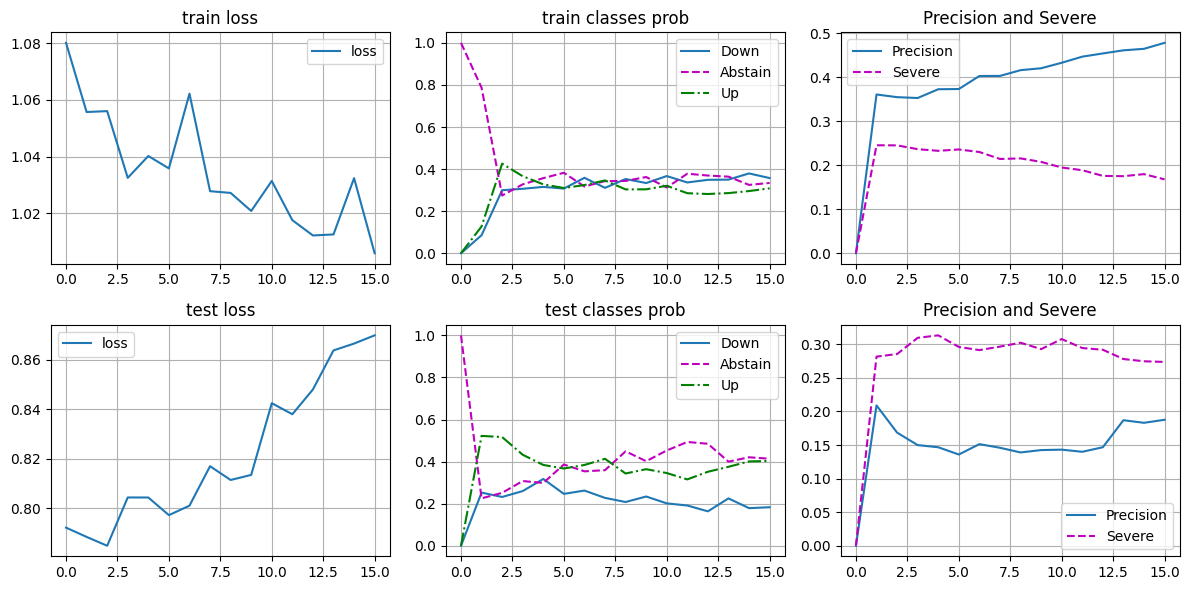

100%|██████████| 100/100 [00:00<00:00, 269.62it/s]


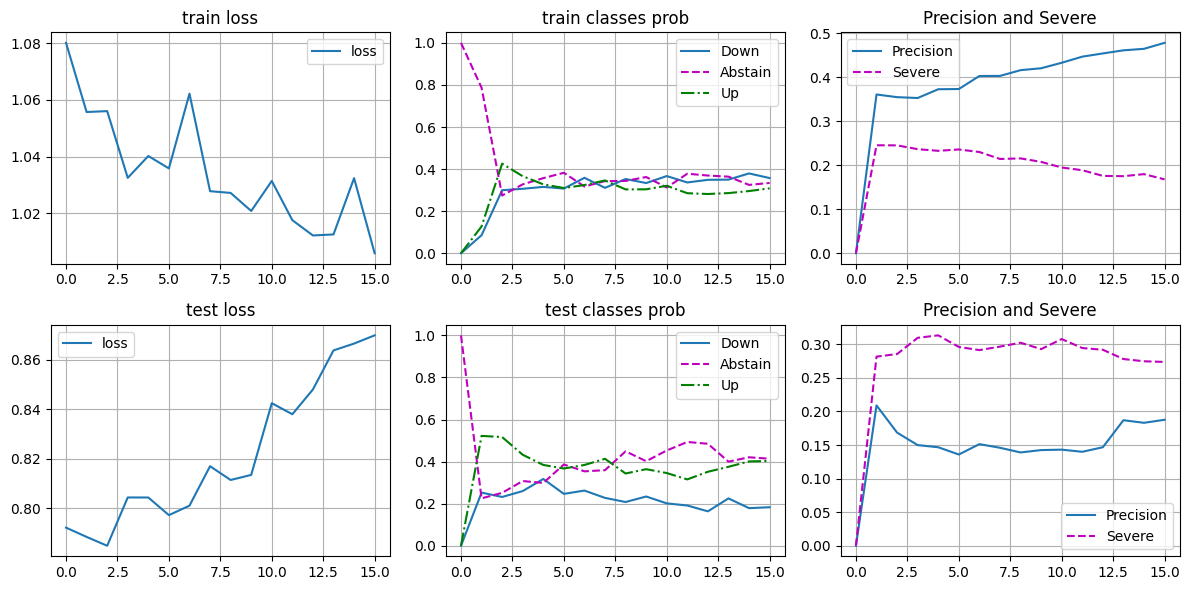

In [64]:

train = ModelTrain(model = model,
                   train_set = train_set,
                   validation_set=validation_set,
                   test_set=test_set,
                   loss_fn = loss_fn,
                   optimizer = optimizer,
                   scheduler=scheduler,
                   recorder=recorder,
                   graph=animator,
                   threshold = 45,
                   )
train.epoch_train(epochs = 15, round = 100, early_stop = 30)

In [65]:
print(BackTest(model, *train_set.all(),sliding_window=5,init_value=3000))
train.round(round = 100, is_train = False, use_set = 'train', print_summary = True)

yearly return :44.78%
std           :87.55%
sharpe ratio  :0.48


100%|██████████| 100/100 [00:00<00:00, 256.61it/s]


,Prediction Ratio,Precision: Right/Pred,Severe: Wrong/Pred,Real Ratio,Accuracy: Right/Real
分类 0 (悲观),32.36%,51.73%,15.05%,27.19%,61.57%
分类 1 (放弃),32.50%,51.38%,0.00%,41.35%,40.39%
分类 2 (乐观),35.14%,44.82%,15.62%,31.46%,50.06%
分类 0 + 分类 2,67.50%,48.13%,15.35%,58.65%,55.40%


In [66]:
print(BackTest(model, *validation_set.all(),sliding_window=5,init_value=3000))
train.round(round = 100, is_train = False, use_set = 'validation', print_summary = True)

yearly return :-5.33%
std           :55.80%
sharpe ratio  :-0.15


100%|██████████| 100/100 [00:00<00:00, 274.18it/s]


,Prediction Ratio,Precision: Right/Pred,Severe: Wrong/Pred,Real Ratio,Accuracy: Right/Real
分类 0 (悲观),18.58%,28.47%,30.25%,29.95%,17.66%
分类 1 (放弃),41.09%,46.92%,0.00%,50.84%,37.92%
分类 2 (乐观),40.33%,13.89%,26.88%,19.21%,29.15%
分类 0 + 分类 2,58.91%,18.49%,27.94%,49.16%,22.15%


In [67]:
print(BackTest(model, *test_set.all(),sliding_window=5,init_value=3000))
train.round(round = 100, is_train = False, use_set = 'test', print_summary = True)

yearly return :-4.68%
std           :43.82%
sharpe ratio  :-0.18


100%|██████████| 100/100 [00:00<00:00, 262.51it/s]


,Prediction Ratio,Precision: Right/Pred,Severe: Wrong/Pred,Real Ratio,Accuracy: Right/Real
分类 0 (悲观),14.80%,18.38%,27.16%,22.55%,12.06%
分类 1 (放弃),48.47%,63.40%,0.00%,62.60%,49.09%
分类 2 (乐观),36.73%,11.49%,23.69%,14.85%,28.42%
分类 0 + 分类 2,51.53%,13.47%,24.68%,37.40%,18.56%


In [68]:
# torch.save(model.state_dict(), 'params/baseline.params')